<a href="https://colab.research.google.com/github/RakhithaBaburaj/DEMENTIA-DETECTION-USING-MACHINE-LEARNING-WEB-INTEGRATION/blob/main/new_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from nets import *
import time,os,copy,argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install torchsummary

In [ ]:
train_directory = '/content/drive/MyDrive/Datasets/Alzheimer_sDataset/train/'
test_directory ='/content/drive/MyDrive/Datasets/Alzheimer_sDataset/test/'

In [ ]:
batch_sz = 64
num_epochs = 5
num_classes = 4
num_cpu = multiprocessing.cpu_count()

In [ ]:
num_cpu

2

In [ ]:
img_transform  = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale=(0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

}

In [ ]:
datasets = {
    'train' : datasets.ImageFolder(root = train_directory ,transform=img_transform['train']),
    'test'  : datasets.ImageFolder(root = test_directory ,transform=img_transform['test'])
}

AttributeError: 'dict' object has no attribute 'ImageFolder'

In [ ]:
datasets_size = {
    'train':len(datasets['train']),
    'test':len(datasets['test'])
}

In [ ]:
dataloaders = {
    'train':data.DataLoader(datasets['train'],batch_size = batch_sz ,shuffle = True,num_workers=num_cpu,pin_memory=True,drop_last=True),
    'test':data.DataLoader(datasets['test'],batch_size=batch_sz,shuffle=True,num_workers=num_cpu,pin_memory=True,drop_last=True)
}

In [ ]:
class_name = datasets['train'].classes
print(f'class_name = {class_name}')

class_name = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model_t = models.resnet18(pretrained = True)
num_ft  = model_t.fc.in_features
model_t.fc = nn.Linear(num_ft,num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_t = model_t.to(device)

In [ ]:
for num,(name,parm) in enumerate(model_t.named_parameters()):
    print(num,name,parm.requires_grad)
summary(model_t,input_size=(3,224,224))
print(model_t)

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.1.conv1.weight True
10 layer1.1.bn1.weight True
11 layer1.1.bn1.bias True
12 layer1.1.conv2.weight True
13 layer1.1.bn2.weight True
14 layer1.1.bn2.bias True
15 layer2.0.conv1.weight True
16 layer2.0.bn1.weight True
17 layer2.0.bn1.bias True
18 layer2.0.conv2.weight True
19 layer2.0.bn2.weight True
20 layer2.0.bn2.bias True
21 layer2.0.downsample.0.weight True
22 layer2.0.downsample.1.weight True
23 layer2.0.downsample.1.bias True
24 layer2.1.conv1.weight True
25 layer2.1.bn1.weight True
26 layer2.1.bn1.bias True
27 layer2.1.conv2.weight True
28 layer2.1.bn2.weight True
29 layer2.1.bn2.bias True
30 layer3.0.conv1.weight True
31 layer3.0.bn1.weight True
32 layer3.0.bn1.bias True
33 layer3.0.conv2.weight True
34 layer3.0.bn2.weight True
35 layer3.0.bn2.bias True
36 l

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft  = optim.SGD(model_t.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Tensorboard summary
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasets_size[phase]
            epoch_acc = running_corrects.double() / datasets_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model_t, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
# Save the entire model
print("\nSaving the model...")
torch.save(model_ft,'/content/drive/MyDrive/Datasets/model.pth' )

Epoch 0/4
----------
train Loss: 0.9589 Acc: 0.5470
test Loss: 1.0243 Acc: 0.5090

Epoch 1/4
----------
train Loss: 0.8264 Acc: 0.6061
test Loss: 0.8985 Acc: 0.5706

Epoch 2/4
----------
train Loss: 0.7665 Acc: 0.6471
test Loss: 0.8579 Acc: 0.6073

Epoch 3/4
----------
train Loss: 0.7570 Acc: 0.6553
test Loss: 0.8579 Acc: 0.6066

Epoch 4/4
----------
train Loss: 0.7509 Acc: 0.6567
test Loss: 0.8580 Acc: 0.6081

Training complete in 3m 4s
Best val Acc: 0.000000

Saving the model...


AttributeError: Can't pickle local object 'summary.<locals>.register_hook.<locals>.hook'

# New Section

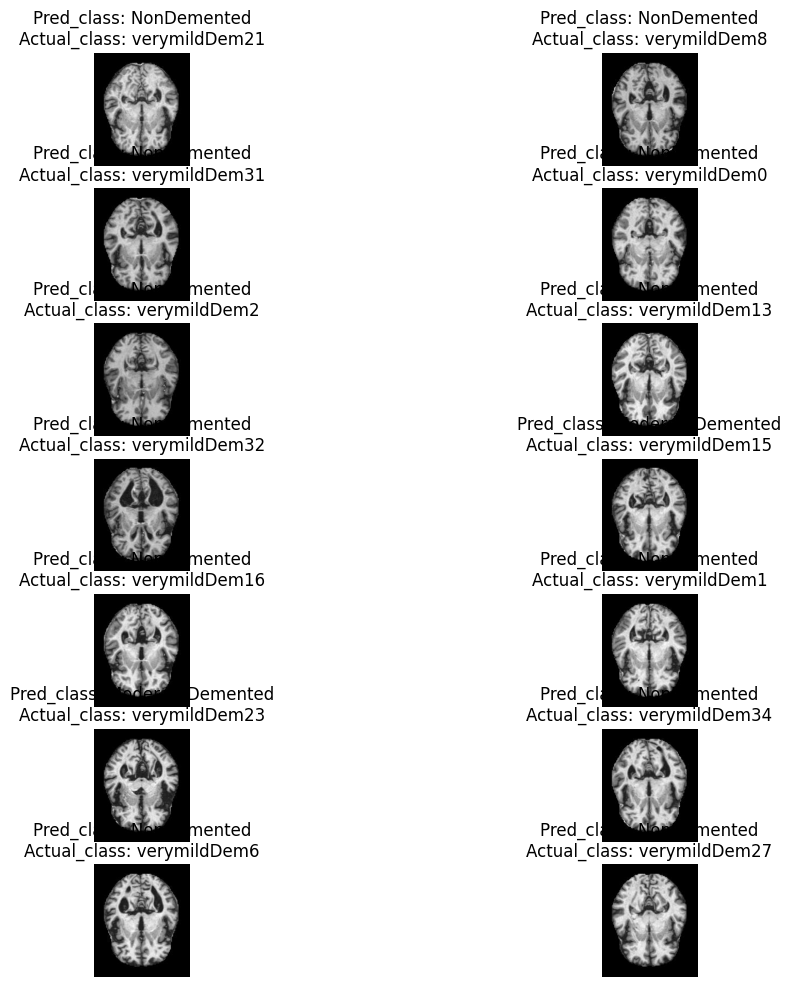

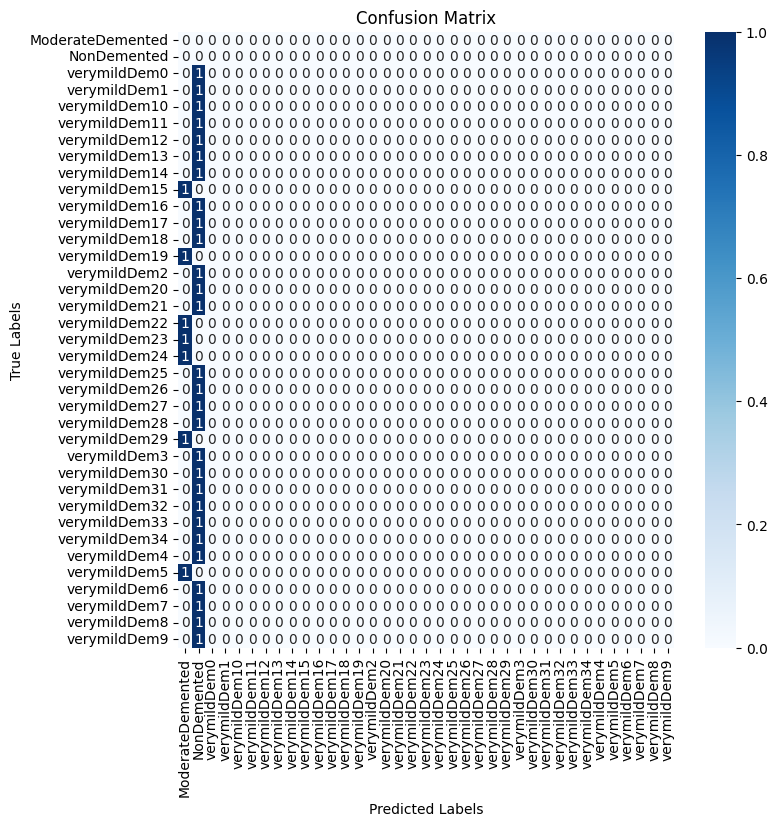

In [ ]:
from PIL import Image
from pathlib import Path
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

im_dir = '/content/test/'
m = '/content/drive/MyDrive/Datasets/model.pth'

# Assuming you have a device defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(m, map_location=device)  # Load the model, specifying device
model.eval()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Use Path to list all image files in the directory
image_paths = list(Path(im_dir).resolve().glob('*'))

# Lists to store ground truth and predictions
ground_truth_labels = []
predicted_labels = []

fig = plt.figure(figsize=(12, 12))

row, col =7 , 2  # Display in a 3x3 grid

preprocess = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

with torch.no_grad():

    for num, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert('RGB')
        ground_truth_label = img_path.stem.split('_')[-1]  # Assuming your file names contain the ground truth label
        ground_truth_labels.append(ground_truth_label)

        inputs = preprocess(img).unsqueeze(0).to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        predicted_label = class_names[pred]
        predicted_labels.append(predicted_label)

        # Adjust indexing to start from 1
        plt.subplot(row, col, num % (row * col) + 1)

        plt.title("Pred_class: " + predicted_label + "\nActual_class: " + ground_truth_label)
        plt.axis('off')
        plt.imshow(img)

plt.show()

# Identify unique labels dynamically
unique_labels = sorted(list(set(ground_truth_labels + predicted_labels)))

# Create confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels, labels=unique_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Flatten the confusion matrix sums into 1D arrays for true labels and predicted labels
true_labels = ["Positive"] * sum_TP + ["Negative"] * sum_TN + ["Positive"] * sum_FN + ["Negative"] * sum_FP
predicted_labels = ["Positive"] * (sum_TP + sum_FP) + ["Negative"] * (sum_FN + sum_TN)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, pos_label="Positive")
recall = recall_score(true_labels, predicted_labels, pos_label="Positive")
f1score = f1_score(true_labels, predicted_labels, pos_label="Positive")

# Print accuracy, precision, recall, and F1-score
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)

# Generate classification report
target_names = ["Positive", "Negative"]
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))